# Data Extraction

In [1]:
import chess.pgn
import csv

# Function to parse PGN file and extract game data
def parse_pgn(pgn_file):
    games = []
    with open(pgn_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            games.append(game)
    return games

# Function to extract game data and save to CSV
def save_to_csv(games, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Event', 'Site', 'Date', 'Round', 'White', 'Black', 'Result', 'Moves']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for game in games:
            headers = game.headers
            moves = game.board().variation_san(game.mainline_moves())
            writer.writerow({
                'Event': headers.get('Event', ''),
                'Site': headers.get('Site', ''),
                'Date': headers.get('Date', ''),
                'Round': headers.get('Round', ''),
                'White': headers.get('White', ''),
                'Black': headers.get('Black', ''),
                'Result': headers.get('Result', ''),
                'Moves': moves
            })

# Example usage
pgn_file = "s2.pgn"
output_csv_file = "games2.csv"
games = parse_pgn(pgn_file)
save_to_csv(games, output_csv_file)


# Data Preprocessing

In [2]:
import pandas as pd
df = pd.read_csv('games2.csv')


In [3]:
df.head()

,Event,Site,Date,Round,White,Black,Result,Moves
0,Rated Blitz game,https://lichess.org/Fq2VpsDf,2024.03.08,?,DrDubious,saubhagya,1-0,1. b3 d5 2. Bb2 c5 3. e3 Nc6 4. Qe2 e5 5. Nc3 ...
1,CHESS CLASH FREE TOURNAMENT,https://lichess.org/Po6vNzPQ,2024.02.07,?,neps10,saubhagya,1-0,1. e4
2,Casual Blitz game,https://lichess.org/p1bJdfhi,2023.11.05,?,VEDANG_KHARE,saubhagya,0-1,1. e4 c5 2. Nf3 Nc6 3. Bc4 e6 4. O-O g6 5. c3 ...
3,Casual Blitz game,https://lichess.org/qL6GhIQr,2023.11.05,?,saubhagya,soham2409,1-0,1. e4 c5 2. Nf3 e6 3. Bc4 Nf6 4. Nc3 Nc6 5. O-...
4,Casual Blitz game,https://lichess.org/uDULwmo7,2023.10.30,?,saubhagya,krunalshirodkar,1-0,1. e4 d6 2. d4 Nf6 3. Bd3 c6 4. Ne2 Qa5+ 5. c3...


In [4]:
columns_to_drop = ['Event', 'Site', 'Date','Round']
df.drop(columns=columns_to_drop,inplace=True)

In [5]:
df.head()

,White,Black,Result,Moves
0,DrDubious,saubhagya,1-0,1. b3 d5 2. Bb2 c5 3. e3 Nc6 4. Qe2 e5 5. Nc3 ...
1,neps10,saubhagya,1-0,1. e4
2,VEDANG_KHARE,saubhagya,0-1,1. e4 c5 2. Nf3 Nc6 3. Bc4 e6 4. O-O g6 5. c3 ...
3,saubhagya,soham2409,1-0,1. e4 c5 2. Nf3 e6 3. Bc4 Nf6 4. Nc3 Nc6 5. O-...
4,saubhagya,krunalshirodkar,1-0,1. e4 d6 2. d4 Nf6 3. Bd3 c6 4. Ne2 Qa5+ 5. c3...


In [6]:
# Check for missing values
print(df.isnull().sum())

White      0
Black      0
Result     0
Moves     21
dtype: int64


In [7]:
df.dropna(subset=['Moves'], inplace=True)


In [8]:
print(df.isnull().sum())


White     0
Black     0
Result    0
Moves     0
dtype: int64


In [9]:
df.to_csv('cleaned_data4.csv', index=False)

In [10]:
pip install python-chess


Note: you may need to restart the kernel to use updated packages.


# Setting Up Chessboard

In [11]:
import chess
import chess.engine
import random
import numpy

In [12]:
def default_board():
    board=chess.Board()
    return board

def random_board(max_depth=200):
    board=chess.Board()
    depth=random.randrange(0,max_depth)

    for _ in range(depth):
        all_moves=list(board.legal_moves)
        random_move=random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break
    return board

    

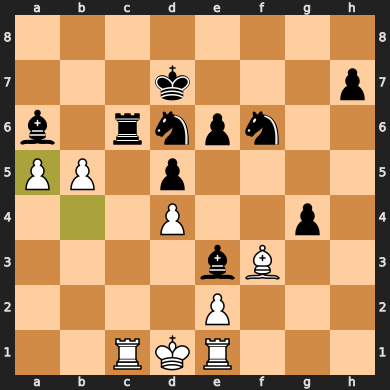

In [13]:
test_board=random_board()
test_board
#random chessboard is generated

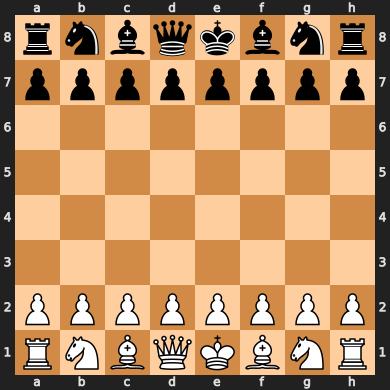

In [14]:
board=default_board()
board

# Setting Up Evaluation Engine

In [15]:
# Here we will be using the Stockfish engine
import os

def eval(board,depth):
    with chess.engine.SimpleEngine.popen_uci('stockfish/st') as sf:
        result=sf.analyse(board,chess.engine.Limit(depth=depth))
        score=result['score'].white().score()
        return (score/100)

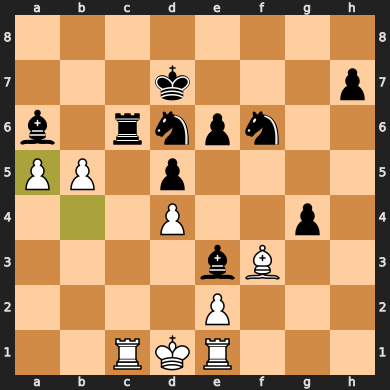

In [16]:
test_board

# Moving Pieces Legally on the board

In [17]:
def play(board, notation):
    try:
        curr_move = chess.Move.from_uci(notation)
        if curr_move not in board.legal_moves:
            print("Illegal move:", notation)
            return False
        temp_board = board.copy()
        temp_board.push(curr_move)
        if temp_board.is_check():
            print("Move puts the king in check:", notation)
            return False
        board.push(curr_move)
        return True
    except ValueError:
        print("Invalid move format:", notation)
        return False


In [18]:
play(test_board,'e4e5')

Illegal move: e4e5


False

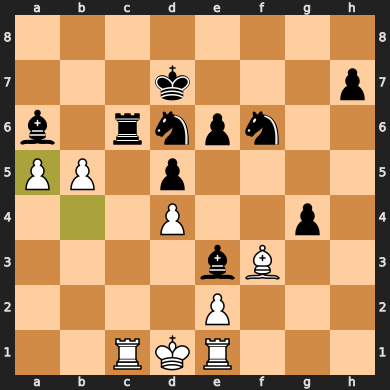

In [19]:
test_board

In [20]:
play(test_board,'a6a5')# cant capture your own piece

play(test_board,'a6b5')#cant move the king on a checked square

Illegal move: a6a5


True

# Setting up the BitBoard

In [21]:
import chess

class ChessBitboard:
    def __init__(self, fen=None):
        if fen is None:
            self.board = chess.Bitboard()  # Initialize an empty board
        else:
            self.board = chess.Bitboard(fen)

    def generate_legal_moves(self):
        return list(self.board.generate_legal_moves())
    


In [22]:
myboard=ChessBitboard()

In [23]:
myboard

# Playing moves and converting a board to fen

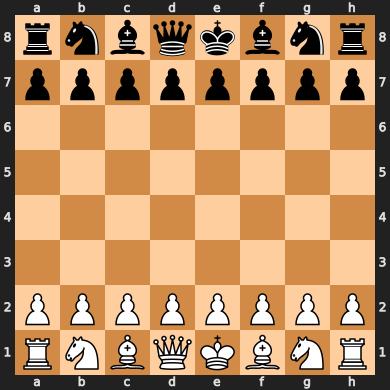

In [24]:
board

In [25]:
play(board,'e2e4')
play(board,'e7e5')

True

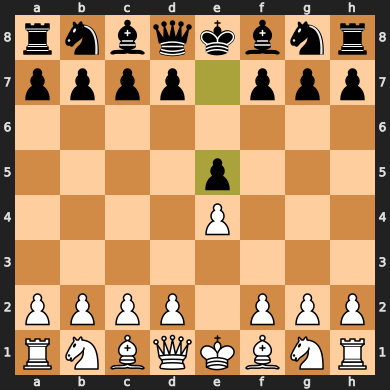

In [26]:
board

In [27]:
play(board,'g1f3')
play(board,'b8c6')

True

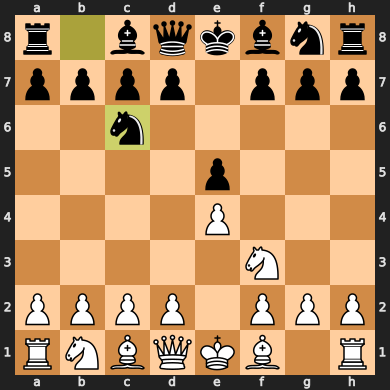

In [28]:
board

In [29]:
play(board,'d2d4')
play(board,'e5d4')

True

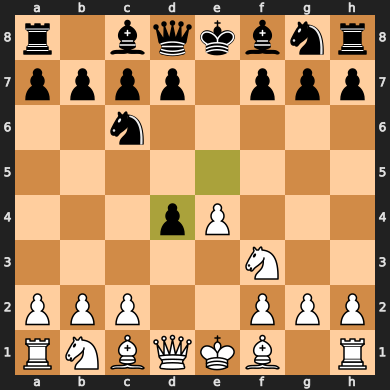

In [30]:
board

In [31]:
play(board,'f1c4')

True

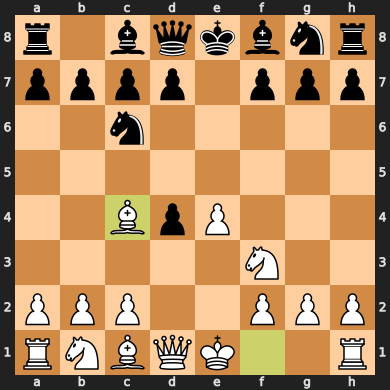

In [32]:
board

In [33]:
bitboard_fen = board.board_fen()


In [34]:
import chess

def moreinfo(board):
    # Get piece placement
    piece_placement = board.piece_map()

    # Get active color
    active_color = "White" if board.turn == chess.WHITE else "Black"

    # Get castling availability
    castling_availability = board.castling_rights

    # Get en passant target square
    en_passant_target = board.ep_square

    # Get halfmove clock
    halfmove_clock = board.halfmove_clock

    # Get fullmove number
    fullmove_number = board.fullmove_number

    print("Piece placement:", piece_placement, "\n")
    print("Active color:", active_color, "\n")
    print("En passant target square:", en_passant_target, "\n")
    print("Halfmove clock:", halfmove_clock, "\n")
    print("Fullmove number:", fullmove_number, "\n")

In [35]:
moreinfo(board)

Piece placement: {63: Piece.from_symbol('r'), 62: Piece.from_symbol('n'), 61: Piece.from_symbol('b'), 60: Piece.from_symbol('k'), 59: Piece.from_symbol('q'), 58: Piece.from_symbol('b'), 56: Piece.from_symbol('r'), 55: Piece.from_symbol('p'), 54: Piece.from_symbol('p'), 53: Piece.from_symbol('p'), 51: Piece.from_symbol('p'), 50: Piece.from_symbol('p'), 49: Piece.from_symbol('p'), 48: Piece.from_symbol('p'), 42: Piece.from_symbol('n'), 28: Piece.from_symbol('P'), 27: Piece.from_symbol('p'), 26: Piece.from_symbol('B'), 21: Piece.from_symbol('N'), 15: Piece.from_symbol('P'), 14: Piece.from_symbol('P'), 13: Piece.from_symbol('P'), 10: Piece.from_symbol('P'), 9: Piece.from_symbol('P'), 8: Piece.from_symbol('P'), 7: Piece.from_symbol('R'), 4: Piece.from_symbol('K'), 3: Piece.from_symbol('Q'), 2: Piece.from_symbol('B'), 1: Piece.from_symbol('N'), 0: Piece.from_symbol('R')} 

Active color: Black 

En passant target square: None 

Halfmove clock: 1 

Fullmove number: 4 



In [36]:
df.head()

,White,Black,Result,Moves
0,DrDubious,saubhagya,1-0,1. b3 d5 2. Bb2 c5 3. e3 Nc6 4. Qe2 e5 5. Nc3 ...
1,neps10,saubhagya,1-0,1. e4
2,VEDANG_KHARE,saubhagya,0-1,1. e4 c5 2. Nf3 Nc6 3. Bc4 e6 4. O-O g6 5. c3 ...
3,saubhagya,soham2409,1-0,1. e4 c5 2. Nf3 e6 3. Bc4 Nf6 4. Nc3 Nc6 5. O-...
4,saubhagya,krunalshirodkar,1-0,1. e4 d6 2. d4 Nf6 3. Bd3 c6 4. Ne2 Qa5+ 5. c3...


# Converting the moves to numerical values

In [37]:
square_index={
    'a':0,
    'b':1,
    'c':2,
    'd':3,
    'e':4,
    'f':5,
    'g':6,
    'h':7
}

def square_to_index(square):
    letter=chess.square_name(square)
    return 8- int(letter[1]),square_index[letter[0]]

def split_dims(board):
    board3d=numpy.zeros((14,8,8),dtype=numpy.int8)
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece,chess.WHITE):
            idx=numpy.unravel_index(square,(8,8))
            board3d[piece-1][7-idx[0]][idx[1]] =1
        for square in board.pieces(piece,chess.BLACK):
            idx=numpy.unravel_index(square,(8,8))
            board3d[piece+5][7-idx[0]][idx[1]]=1

    aux=board.turn
    board.turn=chess.WHITE
    for move in board.legal_moves:
        i,j=square_to_index(move.to_square)
        board3d[12][i][j]=1
    board.turn=chess.BLACK
    for move in board.legal_moves:
        i,j=square_to_index(move.to_square)
        board3d[13][i][j]=1
    board.turn=aux
    return board3d
    


In [38]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [39]:
moves=pd.DataFrame(df['Moves'])

In [40]:
moves.head()

,Moves
0,1. b3 d5 2. Bb2 c5 3. e3 Nc6 4. Qe2 e5 5. Nc3 ...
1,1. e4
2,1. e4 c5 2. Nf3 Nc6 3. Bc4 e6 4. O-O g6 5. c3 ...
3,1. e4 c5 2. Nf3 e6 3. Bc4 Nf6 4. Nc3 Nc6 5. O-...
4,1. e4 d6 2. d4 Nf6 3. Bd3 c6 4. Ne2 Qa5+ 5. c3...


In [41]:
import re
import pandas as pd
import chess

def generate_fen_for_game(game_moves):
    fen_list = []
    board = chess.Board()
    for move in game_moves:
        try:
            board.push_san(move)
            fen_list.append(board.fen())
        except ValueError as e:
            print("Error processing move:", move)
            print("Reason:", e)
        except Exception as e:
            print("Unexpected error processing move:", move)
            print("Reason:", e)
    return fen_list

def process_moves(moves_str):
    moves = re.findall(r'\b(?:\d+\.\s*)?(\S+)\b', moves_str)
    return generate_fen_for_game(moves)

# Apply the function to each row of the DataFrame to generate FENs for each game
all_fens = moves['Moves'].apply(process_moves)


In [42]:
print(all_fens)

0       [rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...
1       [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
2       [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
3       [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
4       [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
                              ...                        
1773    [rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...
1774    [rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...
1775    [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
1776    [rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...
1777    [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
Name: Moves, Length: 1757, dtype: object


In [43]:
print(all_fens[1])

['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1']


# Setting Up the ML Model

In [44]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [45]:
type(all_fens)

pandas.core.series.Series

In [46]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np

# Check if all lists have the same length
list_lengths = all_fens.apply(len)
if len(set(list_lengths)) == 1:
    # All lists have the same length, proceed with conversion
    max_length = list_lengths.iloc[0]
    all_fens_np = np.array(all_fens.to_list())
else:
    # Handle inconsistency (e.g., by padding or removing elements)
    # For example, if we want to pad the lists to the maximum length:
    max_length = max(list_lengths)
    all_fens_padded = all_fens.apply(lambda x: x + [''] * (max_length - len(x)))
    all_fens_np = np.array(all_fens_padded.to_list())

# Output the shape of the resulting numpy array
print("Shape of the resulting numpy array:", all_fens_np.shape)


Shape of the resulting numpy array: (1757, 203)


In [48]:
print(all_fens_np)

[['rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'
  'rnbqkbnr/ppp1pppp/8/3p4/8/1P6/P1PPPPPP/RNBQKBNR w KQkq - 0 2'
  'rnbqkbnr/ppp1pppp/8/3p4/8/1P6/PBPPPPPP/RN1QKBNR b KQkq - 1 2' ... ''
  '' '']
 ['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1' '' '' ...
  '' '' '']
 ['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'
  'rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2'
  'rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2' ... ''
  '' '']
 ...
 ['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'
  'rnbqkbnr/pp1ppppp/2p5/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2'
  'rnbqkbnr/pp1ppppp/2p5/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2' ... ''
  '' '']
 ['rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1'
  'rnbqkbnr/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2'
  'rnbqkbnr/pppp1ppp/4p3/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2' ... ''
  '' '']
 ['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'
  'rnbqkb

In [49]:
import numpy as np
import chess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten

# Prepare Data
X = []  # List to store 3D board representations
y = []  # List to store next moves

# Iterate over all FEN positions
for game_fens in all_fens:
    for i in range(len(game_fens) - 1):
        current_fen = game_fens[i]
        next_fen = game_fens[i + 1]
        
        # Convert current FEN position to 3D board representation
        board = chess.Board(current_fen)
        board_3d = split_dims(board)
        
        # Append 3D board representation to features (X)
        X.append(board_3d)
        
        # Append next move to labels (y)
        next_move = next_fen.split()[-1]  # Extract next move from FEN
        y.append(next_move)

# Convert lists to numpy arrays
X = np.array(X)

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build Model
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),  # Input layer with specified shape
    Flatten(),  # Flatten 3D input
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with number of unique moves as classes
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict Moves (for new board positions)
# Use model.predict() with 3D board representations as input to predict moves.
model.save("shadowgm_v2.h5")

Epoch 1/15


C:\Users\saubhagya singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3158/3158 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2388 - loss: 2.4093 - val_accuracy: 0.3552 - val_loss: 1.8358
Epoch 2/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3707 - loss: 1.7660 - val_accuracy: 0.3987 - val_loss: 1.6408
Epoch 3/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4098 - loss: 1.5816 - val_accuracy: 0.4069 - val_loss: 1.6014
Epoch 4/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4437 - loss: 1.4608 - val_accuracy: 0.4320 - val_loss: 1.5266
Epoch 5/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4658 - loss: 1.3753 - val_accuracy: 0.4379 - val_loss: 1.4940
Epoch 6/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4861 - loss: 1.3016 - val_accuracy: 0.4445 - val_loss: 1.4873
Epoch 7/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5038 - loss: 1.2451 - val_accuracy: 0.4624 - val_loss: 1.4358
Epoch 8/15
3158/3158 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5195 - loss: 1.1924 - val_accurac

Test Accuracy: 0.4938041865825653


# Manual Checking with GUI

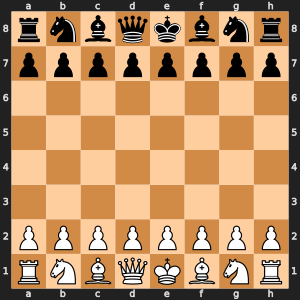


Enter your move (in algebraic notation, e.g., e2e4), or 'quit' to exit:  e4


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Suggested Move: g7g5


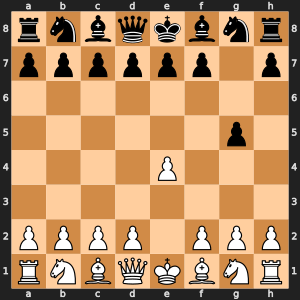

In [ ]:
import numpy as np
import chess
from tensorflow.keras.models import load_model
import chess.svg
from IPython.display import display, SVG

# Load the model
model = load_model("shadowgm_v2.h5")

# Function to preprocess the board
def preprocess_board(board):
    # Convert board to a 3D array
    board_array = np.zeros((1, 14, 8, 8), dtype=np.float32)
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            piece_index = piece.piece_type - 1
            if piece.color == chess.WHITE:
                piece_index += 6
            rank = i // 8
            file = i % 8
            board_array[0][piece_index][rank][file] = 1
    return board_array

# Initialize the board
board = chess.Board()

def play_game(board):
    while not board.is_game_over():
        # Display board as SVG with a smaller size
        display(SVG(chess.svg.board(board=board, size=300)))

        # Prompt user for their move
        user_move = input("\nEnter your move (in algebraic notation, e.g., e2e4), or 'quit' to exit: ")
        
        # Check if user wants to quit
        if user_move.lower() == 'quit' or user_move.lower() == 'exit':
            print("\nExiting the game.")
            break
        
        # Try to make the user's move
        try:
            board.push_san(user_move)
        except ValueError:
            print("Invalid move. Please try again.")
            continue
        
        if board.is_game_over():
            print("\nGame over. Final board:")
            display(SVG(chess.svg.board(board=board, size=300)))
            break

        # Get suggested move from the model
        formatted_board = preprocess_board(board)
        prediction = model.predict(formatted_board)
        suggested_move_index = np.argmax(prediction)
        suggested_move = chess.Move.from_uci(str(list(board.legal_moves)[suggested_move_index]))

        # Make the suggested move
        board.push(suggested_move)

        print("\nSuggested Move:", suggested_move)

# Start the game
play_game(board)
